## <center>Skoltech, Introduction to Data Science</center>
# <center>Gesture classification based on accelerometer data</center>
## <center>Mikhail Kurenkov, Evgenii Safronov</center>

# <center>Gestures recognition gives additional channel to control your devices, e.g. smart home </center>
## <center>Hand movements are different each time, so their classification task is hardly solved by developing some classial algorithm for it.</center>
## <center>Collect dataset of classified hand movements $\rightarrow$ DS methods.</center>

![title](img/wand.jpg)

# <center> Dataset preparation </center>

## <center>1. Raw data from sensors</center>

## <center>2. Filtered noise</center>

## <center>3. Unified size of arrays</center>

## <center><strike>4. Scale and remove mean</strike></center>

In [1]:
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import signal
import fusion
import time
import numpy as np
import sklearn
import seaborn as sns
import pandas as pd
from sklearn.model_selection import GridSearchCV
%matplotlib inline
import warnings; warnings.simplefilter('ignore')

In [2]:
data = []
with open("gyro.dat",'r') as f:
        for line in f:
            result = re.findall(r"-?\d+.\d+", line)
            if len(result) == 10:
                data.append([float(x) for x in result])

In [3]:
fig, ax = plt.subplots(1,2,figsize=(8,4),dpi=600);
#fig.suptitle('Raw data')
ax[0].plot([x[1] for x in data], label='$a_x$');
ax[0].plot([x[2] for x in data], label='$a_y$');
ax[0].plot([x[3] for x in data], label='$a_z$');
ax[0].set_title('Accelerometer');
ax[0].legend(loc='best');
ax[0].set_xlabel('timesteps');
ax[0].set_ylabel(r'$magnitude, \frac{g}{g_0}$');
ax[1].plot([x[4] for x in data], label='$\omega_x$');
ax[1].plot([x[5] for x in data], label='$\omega_y$');
ax[1].plot([x[6] for x in data], label='$\omega_z$');
ax[1].set_title('Gyroscope');
ax[1].legend(loc='best');
ax[1].set_xlabel('timesteps');
ax[1].set_ylabel(r'$\omega $');
fig.tight_layout();
plt.savefig('img/raw_data.png',bbox_inches='tight');
plt.close(fig)

## <center>Raw data from sensors, sample</center>
![title](img/raw_data.png)

In [4]:
fig, ax = plt.subplots(1,2,figsize=(8,4),dpi=600)
labels = ['$a_x$','$a_y$','$a_z$','$\omega_x$','$\omega_y$','$\omega_z$']
for i in range(1, 4):
        x = [x[i] for x in data]
        p = ax[0].plot(signal.filtfilt(*signal.butter(3, 0.2), x),label=labels[i-1])
        ax[0].scatter(range(len(x)),x, color=p[0].get_color(),s=1.5)
        
ax[0].set_title('Accelerometer')
ax[0].legend(loc='best')
ax[0].set_xlabel('timesteps')
ax[0].set_ylabel(r'$magnitude, \frac{g}{g_0}$')

for i in range(4, 7):
        x = [x[i] for x in data]
        p = ax[1].plot(signal.filtfilt(*signal.butter(3, 0.2), x),label=labels[i-1])
        ax[1].scatter(range(len(x)),x, color=p[0].get_color(),s=1.5)

ax[1].set_title('Gyroscope')
ax[1].legend(loc='best')
ax[1].set_xlabel('timesteps')
ax[1].set_ylabel(r'$\omega $')
fig.tight_layout()
plt.savefig('img/filtered_data.png',bbox_inches='tight')
plt.close(fig)

## <center> Filtered noise, sample</center>
![title](img/filtered_data.png)

In [5]:
def discretize_data(data, n_points):
    step = len(data) / n_points
    data = data.transpose()
    res = np.zeros((data.shape[0], n_points))
    for i, x in enumerate(data):
        for j in range(n_points):
            res[i, j] = np.mean(data[i, int(j * step):int((j+1) * step)])
    return res.transpose()
def signal_filter(data, x1, x2):
    data = data.transpose()
    res = np.zeros_like(data)
    for i, x in enumerate(data):
        b, a = signal.butter(x1, x2)
        y = signal.filtfilt(b, a, x)
        res[i] = y
    return res.transpose()

In [6]:
smooth_data = signal_filter(np.array(data)[:,1:7], 3, 0.2) 
discrete_data = discretize_data(smooth_data, 15)

In [7]:
fig, ax = plt.subplots(1,2,figsize=(8,4),dpi=600)
#fig.suptitle('Raw data')
ax[0].plot([x[0] for x in discrete_data], label='$a_x$')
ax[0].plot([x[1] for x in discrete_data], label='$a_y$')
ax[0].plot([x[2] for x in discrete_data], label='$a_z$')
ax[0].set_title('Accelerometer')
ax[0].legend(loc='best')
ax[0].set_xlabel('timesteps')
ax[0].set_ylabel(r'$magnitude, \frac{g}{g_0}$')
ax[1].plot([x[3] for x in discrete_data], label='$\omega_x$')
ax[1].plot([x[4] for x in discrete_data], label='$\omega_y$')
ax[1].plot([x[5] for x in discrete_data], label='$\omega_z$')
ax[1].set_title('Gyroscope')
ax[1].legend(loc='best')
ax[1].set_xlabel('timesteps')
ax[1].set_ylabel(r'$\omega $')
fig.tight_layout()
plt.savefig('img/discrete_data.png',bbox_inches='tight')
plt.close(fig)

## <center> Unified size of arrays & discretization</center>
![title](img/discrete_data.png)

# <center> Load the data </center>

In [8]:
bd = np.load("data_for_recognition/accelerometer/big_data.npy").item()

In [9]:
classes = []
for g_id, gest in enumerate(bd.keys()):
    classes.append({"cl_id":g_id, "cl_name":gest})
classes

[{'cl_id': 0, 'cl_name': 'circle'},
 {'cl_id': 1, 'cl_name': 'horizontal'},
 {'cl_id': 2, 'cl_name': 'vertical'},
 {'cl_id': 3, 'cl_name': 'up_triangle'}]

In [10]:
gests = {}
X = []
y = []
for g_id, gest in enumerate(bd.keys()):
    gests[gest] = g_id
    for gest_sample in bd[gest]:
        X.append(gest_sample.flatten())
        y.append( g_id )
    

In [11]:
len(X)

978

## <center> Now each sample has 90 features </center>
## <center>(15 points for each axe of accelerometer and gyroscope) </center>

# <center> Visualisation </center>

## <center> Plot "densities" of gestures </center>

In [12]:
def make_class_density(name):    
    f, ax = plt.subplots(2,3,figsize=(15, 8))
    gx = [[],[],[],[],[],[]]
    gy = [[],[],[],[],[],[]]
    for g in bd[name]:
        for i,d in enumerate(g.transpose()):
            gx[i] = np.concatenate((gx[i],d))
            gy[i] = np.concatenate((gy[i],list(range(len(d)))))
    cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
    labels = ['$a_x$','$a_y$','$a_z$','$\omega_x$','$\omega_y$','$\omega_z$']
    for i in range(6):
        df = pd.DataFrame(data={'t':gy[i],labels[i]:gx[i]})
        sns.kdeplot(df['t'],df[labels[i]], cmap=cmap, n_levels=60, shade=True, ax=ax[int(i/3)][i%3]);
    f.tight_layout();
    plt.savefig(name+'.png',bbox_inches='tight')

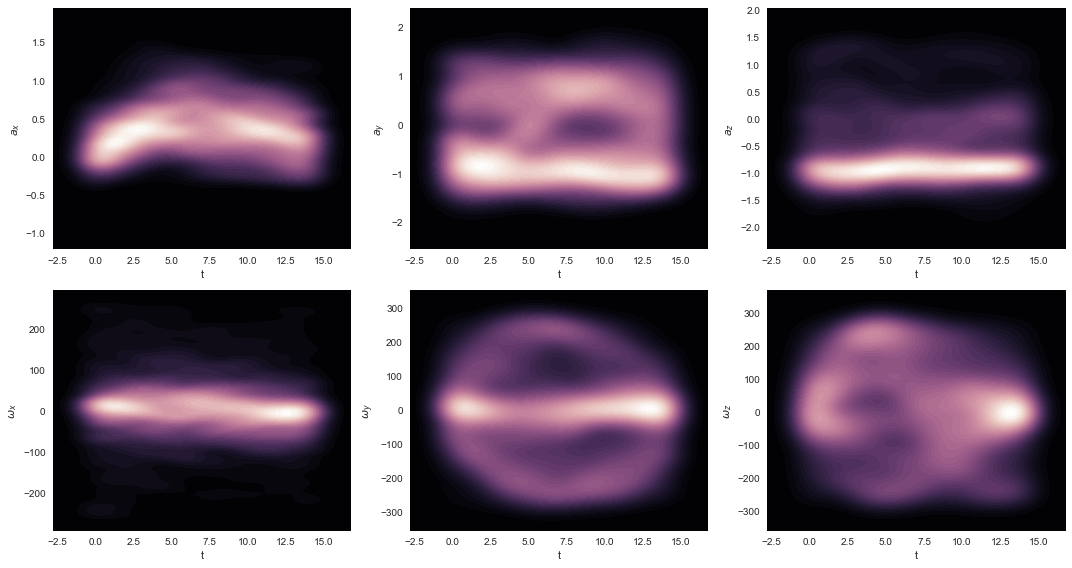

In [13]:
make_class_density('horizontal')

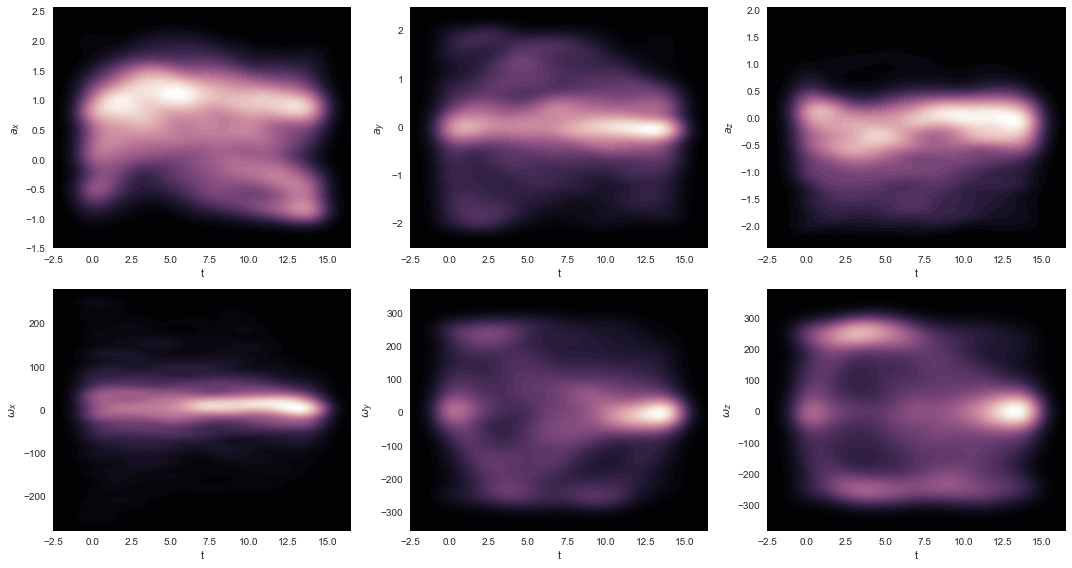

In [14]:
make_class_density('vertical')

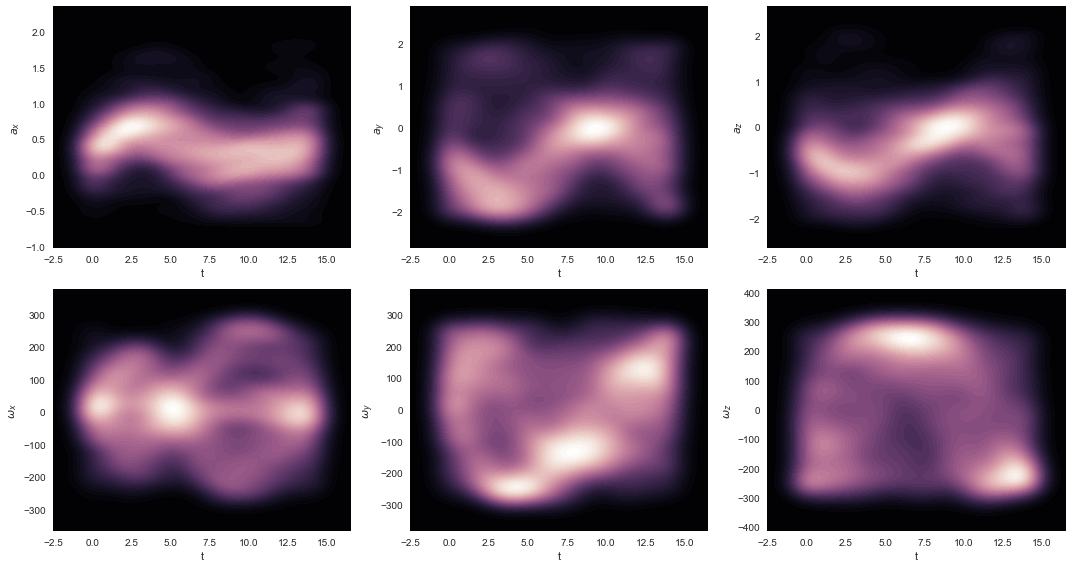

In [15]:
make_class_density('circle')

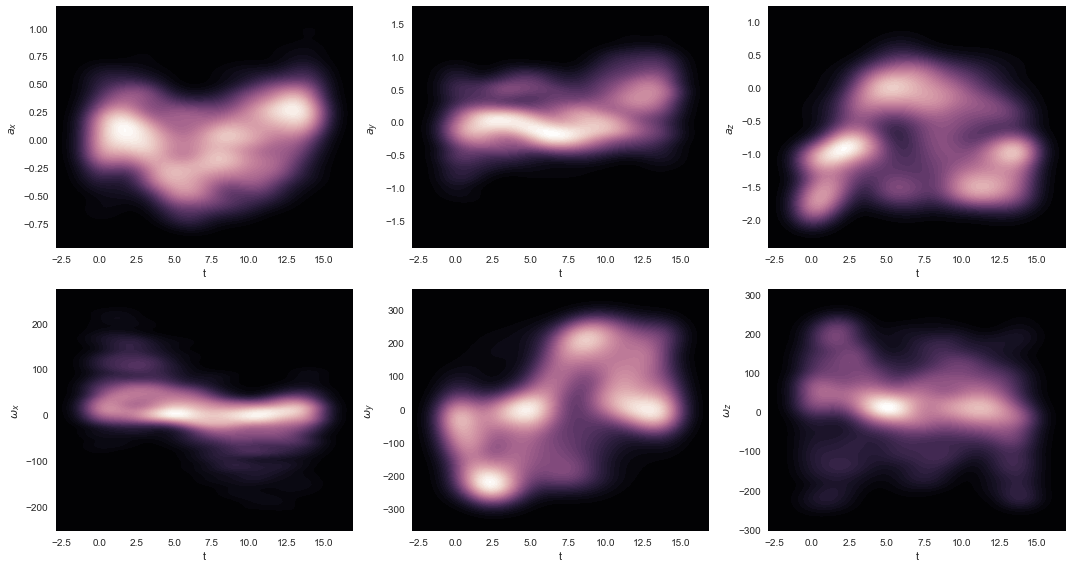

In [16]:
make_class_density('up_triangle')

# Save best classifier

In [17]:
import pickle
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 100)
clf.fit(X, y)

with open('best_classifier.pkl', 'wb') as fid:
    pickle.dump(clf, fid)  

# <center> Density clouds looks different (however, having a lot of intersections),so </center>
# <center> let's start from simple Logistic Regression </center>

## We have 4 target classes, so we need to use StratifiedKFold instead of KFold, but we can use simple Accuracy as measure of quality

# Simple classification methods

In [12]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

## <center>Logistic Regression</center>

In [13]:
kfold = StratifiedKFold(n_splits=10, shuffle=True) 
cv = kfold.split(X, y) 
clf = LogisticRegression()
scores = cross_val_score(clf, X, y, scoring='accuracy', cv=cv)
print('KFold score: {0:.3f} ± {1:.3f}'.format(scores.mean(), scores.std()) )
clf.fit(X, y);

KFold score: 0.666 ± 0.042


In [14]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3), dpi=600, sharey=True)
labels = ['$a_x$','$a_y$','$a_z$','$\omega_x$','$\omega_y$','$\omega_z$']
ax[0].plot(clf.coef_[2][0:15],label=labels[0])
ax[0].plot(clf.coef_[2][15:30],label=labels[1])
ax[0].plot(clf.coef_[2][30:45],label=labels[2])
ax[0].legend(loc='best')
ax[0].set_xlabel('time')
ax[0].set_ylabel('weight')
ax[1].plot(clf.coef_[2][45:60],label=labels[3])
ax[1].plot(clf.coef_[2][60:75],label=labels[4])
ax[1].plot(clf.coef_[2][75:90],label=labels[5])
ax[1].legend(loc='best')
ax[1].set_xlabel('time');
plt.savefig('img/regression_results.png',bbox_inches='tight');
plt.close(fig)

## <center> Some time points got more attention</center>
## <center> That were moments of accelerating and stopping the gesture </center>
![title](img/regression_results.png)

## <center>Not a satisfying result... move further</center>

## <center>to Support Vector Classifier</center>

In [15]:
from sklearn.svm import SVC
kfold = StratifiedKFold(n_splits=10, shuffle=True)
# clf = make_pipeline(StandardScaler(), SVC(kernel='rbf'))
clf = SVC(kernel='rbf')
scores = cross_val_score(clf, X, y, scoring='accuracy', cv=kfold.split(X, y))
print('KFold score: {0:.3f} ± {1:.3f}'.format(scores.mean(), scores.std()) )

KFold score: 0.326 ± 0.003


### <center> SVC has poor perfomance, because of data is neither scaled, not normalized </center>

### <center> Grid search of parameters SVM </center>

In [ ]:
# clf = SVC(kernel='rbf')
# kfold = KFold(n_splits=10, shuffle=True)
# gs = GridSearchCV(clf, param_grid=[{"kernel":["linear", "rbf", "poly", "sigmoid"]}, {"C":[0.1, 0.5, 1, 10]}], 
#                   cv=kfold.split(X, y))
# gs.fit(X, y)
# pd.DataFrame(gs.cv_results_)[["mean_test_score","param_C", "param_kernel"]]

## <center>Confusion matrix</center>

In [35]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
clf = SVC(kernel='rbf', class_weight={0:1, 1:1, 2:1})
y_pred = clf.fit(X_train, y_train).predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)
    plt.figure(figsize=(4, 4), dpi=150)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def make_confusion_matrix(X, y, clf):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    y_pred = clf.fit(X_train, y_train).predict(X_test)
    cnf_matrix = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cnf_matrix, classes=[cl["cl_name"] for cl in classes], normalize=True,
                      title='Normalized confusion matrix')

In [ ]:
# plot_confusion_matrix(cnf_matrix, classes=[cl["cl_name"] for cl in classes], normalize=True,
#                       title='Normalized confusion matrix')
# plt.close()

### feature selection

In [17]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
X_new = SelectKBest(mutual_info_classif, k=80).fit_transform(X, y)
kfold = KFold(n_splits=10, shuffle=True)
clf = SVC(kernel='rbf')
scores = cross_val_score(clf, X_new, y, scoring='accuracy', cv=kfold.split(X_new, y))
print('KFold score: {0:.3f} ± {1:.3f}'.format(scores.mean(), scores.std()) )

KFold score: 0.305 ± 0.045


## Ridge

In [ ]:
from sklearn.linear_model import RidgeClassifier
kfold = KFold(n_splits=10, shuffle=True)
#clf = make_pipeline(StandardScaler(), SVC(kernel='rbf'))
clf = RidgeClassifier()
scores = cross_val_score(clf, X, y, scoring='accuracy', cv=kfold.split(X, y))
print('KFold score: {0:.3f} ± {1:.3f}'.format(scores.mean(), scores.std()) )

In [ ]:
clf = RidgeClassifier()
kfold = KFold(n_splits=10, shuffle=True)
gs = GridSearchCV(clf, param_grid={"alpha":[0.01, 0.1, 0.5, 1, 10, 50, 100]}, cv=kfold.split(X, y))
gs.fit(X, y);

In [ ]:
pd.DataFrame(gs.cv_results_)[["mean_test_score","param_alpha"]]

## <center>Quadratic Discriminant Analysis</center>

In [18]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
kfold = StratifiedKFold(n_splits=10, shuffle=True)
#clf = make_pipeline(StandardScaler(), SVC(kernel='rbf'))
clf = QuadraticDiscriminantAnalysis()
scores = cross_val_score(clf, X, y, scoring='accuracy', cv=kfold.split(X, y))
print('KFold score: {0:.3f} ± {1:.3f}'.format(scores.mean(), scores.std()) )

KFold score: 0.819 ± 0.029


## <center> Hyperparameters optimization </center>

In [19]:
clf = QuadraticDiscriminantAnalysis()
kfold = StratifiedKFold(n_splits=10, shuffle=True)
gs = GridSearchCV(clf, param_grid={"reg_param":[0, 0.01, 0.1, 0.5, 1, 10, 50, 100]}, cv=kfold.split(X, y))
gs.fit(X, y)
pd.DataFrame(gs.cv_results_)[["mean_test_score","param_reg_param"]]

,mean_test_score,param_reg_param
0,0.807771,0
1,0.857873,0.01
2,0.840491,0.1
3,0.792434,0.5
4,0.483640,1
5,0.323108,10
6,0.323108,50
7,0.323108,100


## <center>K nearest neighbors</center>

In [20]:
from sklearn.neighbors import KNeighborsClassifier
kfold = StratifiedKFold(n_splits=10, shuffle=True)
clf = KNeighborsClassifier(3)
scores = cross_val_score(clf, X, y, scoring='accuracy', cv=kfold.split(X, y))
print('KFold score: {0:.3f} ± {1:.3f}'.format(scores.mean(), scores.std()) )

KFold score: 0.885 ± 0.028


In [21]:
kfold = StratifiedKFold(n_splits=10, shuffle=True)
gs = GridSearchCV(KNeighborsClassifier(), param_grid={"n_neighbors":list(range(1, 20))}, 
                  cv=kfold.split(X, y))
gs.fit(X, y);
params = [x['n_neighbors'] for x in gs.cv_results_['params']]
fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=600)
ax.plot(params, gs.cv_results_['mean_test_score'])
ax.set_xlabel('n_neighbors')
ax.set_ylabel('KFold score')
plt.savefig('img/knc_results.png',bbox_inches='tight');
plt.close(fig);

## <center> K neighbors classifier results </center>
![title](img/knc_results.png)

## <center>Decision Tree Classifier</center>

In [36]:
from sklearn.tree import DecisionTreeClassifier

kfold = StratifiedKFold(n_splits=10, shuffle=True)
clf = DecisionTreeClassifier()
scores = cross_val_score(clf, X, y, scoring='accuracy', cv=kfold.split(X, y))
print('KFold score: {0:.3f} ± {1:.3f}'.format(scores.mean(), scores.std()) )

KFold score: 0.823 ± 0.027


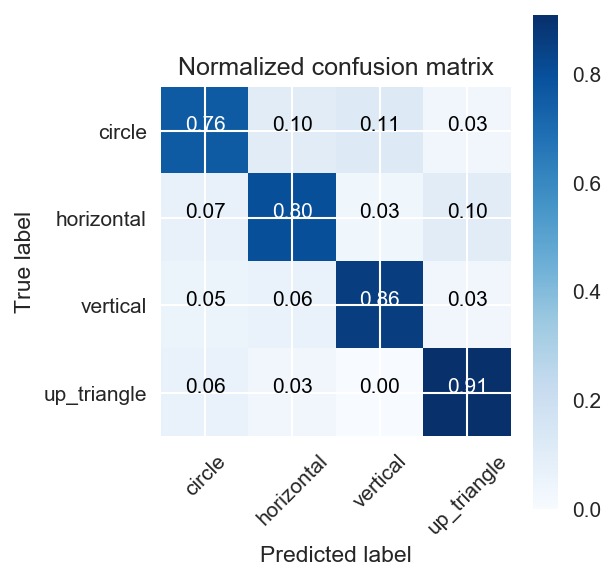

In [37]:
make_confusion_matrix(X,y,DecisionTreeClassifier())

## <center>Random forest</center>

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Normalizer 
#clf = make_pipeline(Normalizer (), RandomForestClassifier())
kfold = StratifiedKFold(n_splits=10, shuffle=True)
clf = RandomForestClassifier(n_estimators = 100)
scores = cross_val_score(clf, X, y, scoring='accuracy', cv=kfold.split(X, y))
print('KFold score: {0:.3f} ± {1:.3f}'.format(scores.mean(), scores.std()) )

KFold score: 0.958 ± 0.022


In [25]:
clf = RandomForestClassifier()
kfold = StratifiedKFold(n_splits=10, shuffle=True)
gs = GridSearchCV(clf, param_grid={"n_estimators":[1, 2, 3, 5, 8, 9, 10, 11, 12, 15, 20, 30, 50, 100]}, 
                  cv=kfold.split(X, y))
gs.fit(X, y)
pd.DataFrame(gs.cv_results_)[["mean_test_score","param_n_estimators"]]

,mean_test_score,param_n_estimators
0,0.771984,1
1,0.744376,2
2,0.852761,3
3,0.877301,5
4,0.913088,8
5,0.922290,9
6,0.930470,10
7,0.913088,11
8,0.931493,12
9,0.930470,15


In [26]:
params = [x['n_estimators'] for x in gs.cv_results_['params']]
fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=600)
plt.plot(params, gs.cv_results_['mean_test_score']);
ax.set_xlabel('n_estimators')
ax.set_ylabel('KFold score')
plt.savefig('img/forest_results.png',bbox_inches='tight');
plt.close(fig);

## <center> Random forest results </center>
![title](img/forest_results.png)

## <center>Gradient boosting classifier</center>

In [27]:
from sklearn.ensemble import GradientBoostingClassifier
kfold = StratifiedKFold(n_splits=10, shuffle=True)
clf = GradientBoostingClassifier()
scores = cross_val_score(clf, X, y, scoring='accuracy', cv=kfold.split(X, y))
print('KFold score: {0:.3f} ± {1:.3f}'.format(scores.mean(), scores.std()) )

KFold score: 0.946 ± 0.018


# Dimension reduction

## PCA

In [28]:
from sklearn.decomposition import PCA

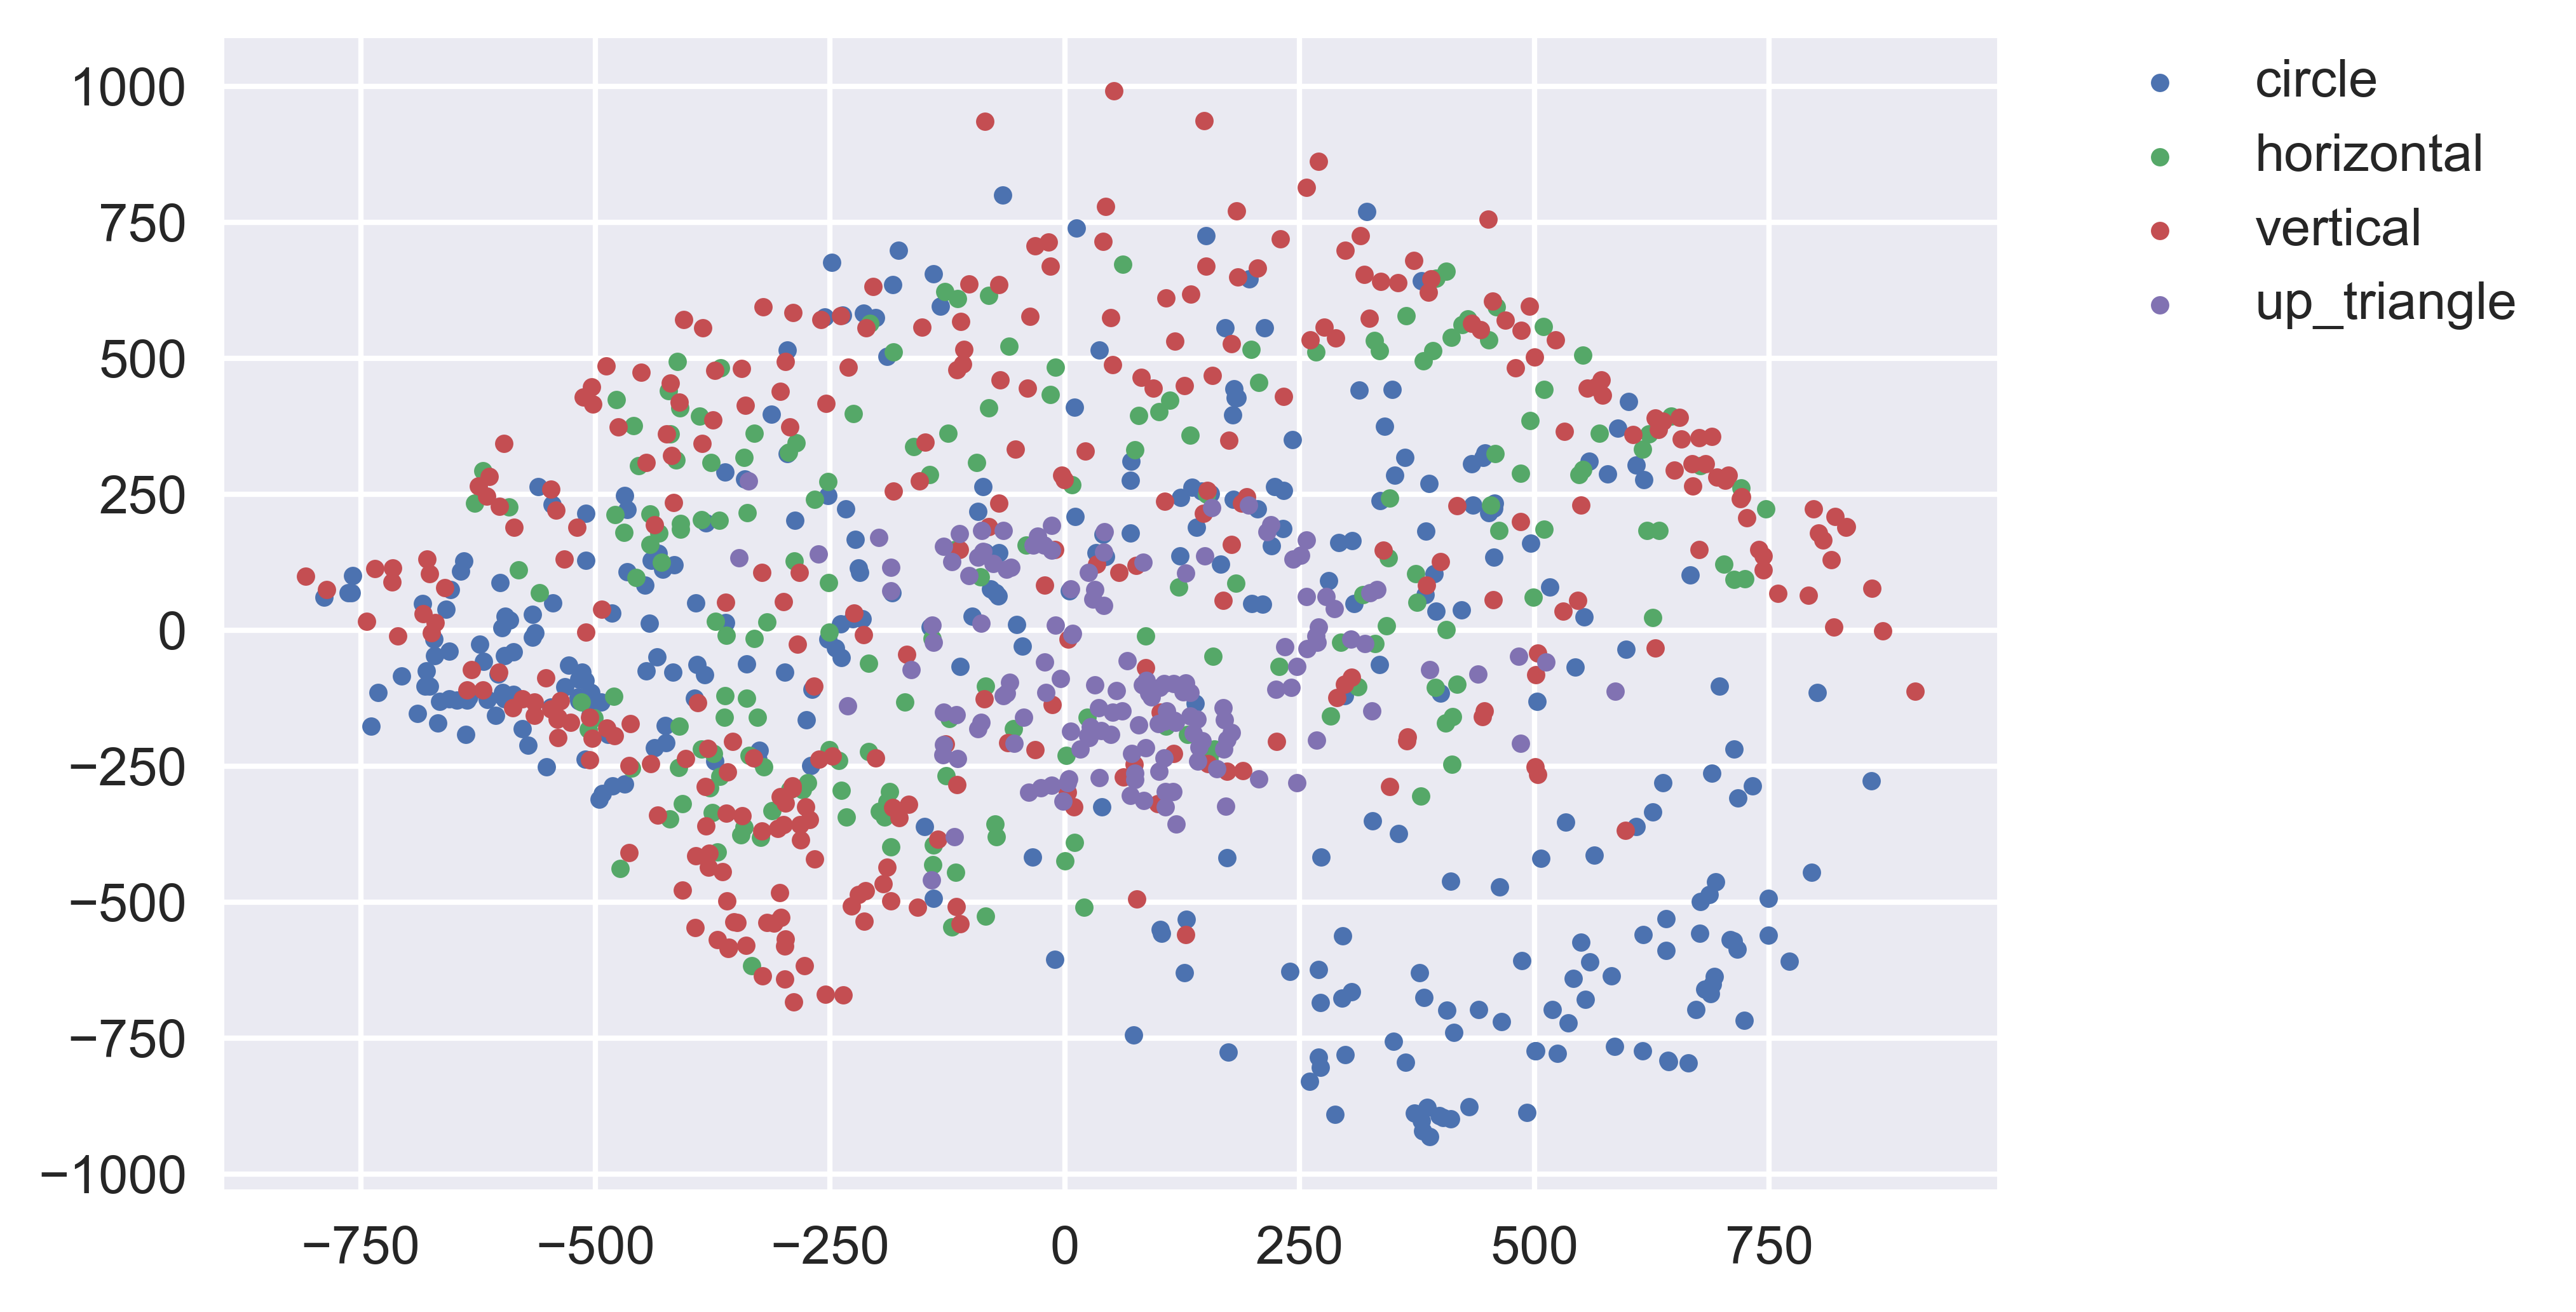

In [29]:
pca = PCA(30)
pca.fit(X)
X_PCA = pca.transform(X)
# sns.lmplot('1 PCA', "2 PCA", X_r[:, 0:1])
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=600)
for cl in classes:
    x = np.array([x_ for y_, x_ in zip(y, X_PCA) if y_ == cl["cl_id"]])
    ax.scatter(x[:,0], x[:, 1], s=10, cmap="jet", label=cl["cl_name"])
#ax.set_ylim(-25, 25)
#ax.set_xlim(-25, 25)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

### Best Classifier with PCA

In [30]:
kfold = StratifiedKFold(n_splits=15, shuffle=True)
#clf = make_pipeline(StandardScaler(), SVC(kernel='rbf'))
clf = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(clf, X_PCA, y, scoring='accuracy', cv=kfold.split(X_PCA, y))
print('KFold score: {0:.3f} ± {1:.3f}'.format(scores.mean(), scores.std()))

KFold score: 0.806 ± 0.062


## Grid search of parameters PCA

In [31]:
clf = make_pipeline(PCA(10), RandomForestClassifier(n_estimators=100))
kfold = StratifiedKFold(n_splits=15, shuffle=True)
gs = GridSearchCV(clf, param_grid={"pca__n_components":[1, 3, 5, 7, 9] + list(range(10, 91, 10))}, cv=kfold.split(X, y))
gs.fit(X, y);

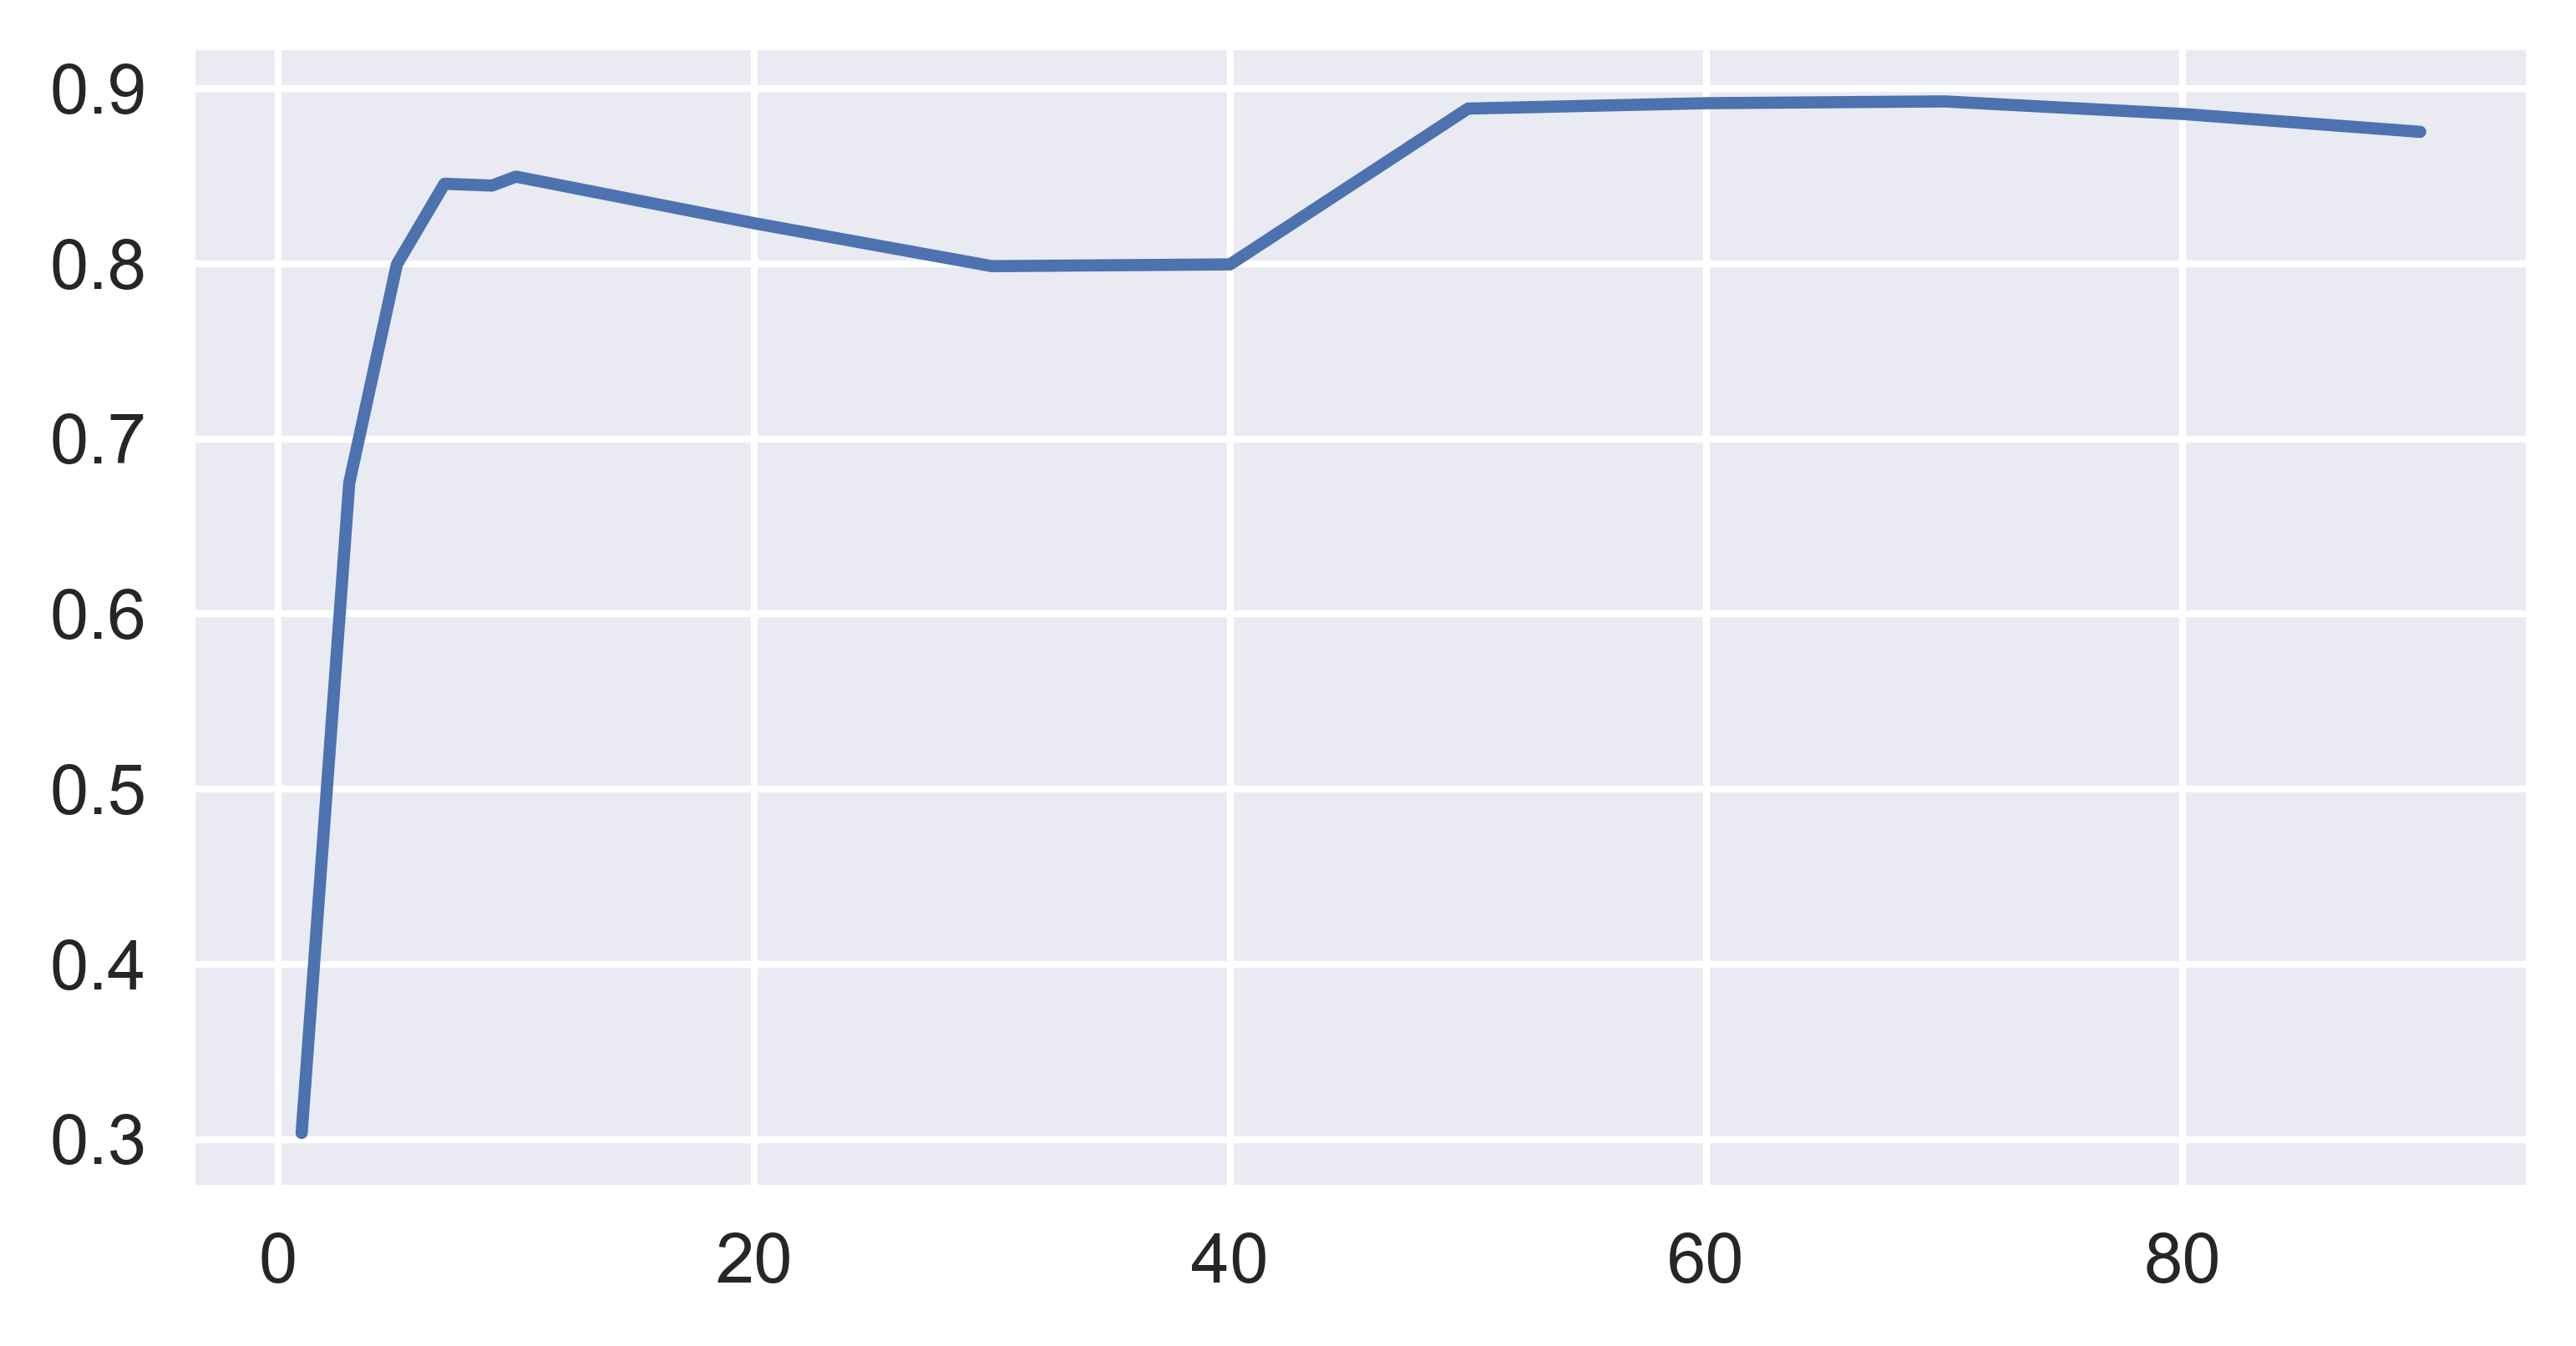

In [32]:
pcas = [x['pca__n_components'] for x in gs.cv_results_['params']]
fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=600)
plt.plot(pcas, gs.cv_results_['mean_test_score'])

### PCA didn't imporve score so it wasn't included into presentation :(

# <center> Interesting findings </center>

## <center> Normalization of data helped for SVC, but in general it made results worse </center>

## <center> 1 neighboor classifier works quite good. </center>
### <center>That might be due to procedure of data collection. We might made a lot of quite similar gestures during generating</center>

# <center> Overall conclusions </center>

## <center> As ML mode was trained on real-life sensors data, it's fully applicable in real-life scenario </center>

## <center> Achieved accuracy (95%) is satisfying for real-life gesture recognition. That means we solved stated problem. </center>

# <center> Thank you for listening! </center> 